In [1]:
%load_ext autoreload

In [20]:
%autoreload
from rdkit import Chem
from chemprop.data.datapoints import MoleculeDatapoint
from chemprop.data.datasets import MoleculeDataset
from chemprop.data import build_dataloader
from chemprop.featurizers.molgraph.molecule import SimpleMoleculeMolGraphFeaturizer
from chemprop.data.collate import BatchMolGraph
import numpy as np
import torch
import pandas as pd
from chemprop.data.datapoints import PolymerDatapoint
from chemprop.data.datasets import PolymerDataset
from chemprop.featurizers.molgraph import PolymerMolGraphFeaturizer
from chemprop.utils import remove_wildcard_atoms
from copy import deepcopy

In [4]:
smi = "[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5~10"

In [22]:
smi2 = "[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O"
mol = Chem.MolFromSmiles(smi2)
rwmol = Chem.RWMol(mol)
rwmol = remove_wildcard_atoms(rwmol)

In [23]:
rwmol_copy = deepcopy(rwmol)
cm = Chem.CombineMols(rwmol, rwmol_copy)
cm = Chem.RWMol(cm)

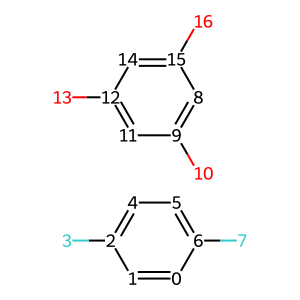

In [24]:
def show_atoms_no(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))

    return mol

rwmolidx = show_atoms_no(rwmol, "atomLabel")
Chem.Draw.MolToImage(rwmolidx)

In [5]:
datapoint = PolymerDatapoint.from_smi(smi, y=1.5)

In [6]:
datapoint

PolymerDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x763c97446030>, fragment_weights=['0.5', '0.5'], edges=['1-3:0.5:0.5', '1-4:0.5:0.5', '2-3:0.5:0.5', '2-4:0.5:0.5~10'], y=1.5, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5~10', V_f=None, E_f=None, V_d=None)

In [7]:
featurizer = PolymerMolGraphFeaturizer()

In [8]:
dp = featurizer(datapoint)

In [ ]:
dp.V_w

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5], dtype=float32)

In [ ]:
dp.E_w

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5])

In [25]:
test_Ew = dp.E_w[::2]

In [31]:
test_Ew.shape
test_Ew

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5])

In [30]:
dp.edge_index[0]

array([ 0,  1,  1,  2,  2,  3,  2,  4,  4,  5,  5,  6,  6,  7,  6,  0,  8,
        9,  9, 10,  9, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 15,  8,
        0,  8,  0, 14,  4,  8,  4, 14])

In [ ]:
print(dp.V.shape)
print(dp.V_w.shape)
print(dp.E.shape)
print(dp.E_w.shape)
print(dp.edge_index.shape)
print(dp.edge_index[0].shape)
print(dp.edge_index[1].shape)

(17, 72)
(17,)
(42, 14)
(42,)
(2, 42)
(42,)
(42,)


In [32]:
test_Ew[dp.edge_index[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
dp.E_w[dp.edge_index[0]].shape

(42,)

In [ ]:
dp.degree_of_poly

2.0

In [33]:
dp.V[dp.edge_index[0]]

array([[0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011],
       [0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011],
       [0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011],
       [0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011],
       [0.     , 0.     , 0.     , ..., 0.     , 1.     , 0.12011]],
      dtype=float32)

In [35]:
V = torch.from_numpy(dp.V)
E = torch.from_numpy(dp.E)
V_w = torch.from_numpy(dp.V_w)
E_w = torch.from_numpy(dp.E_w)
edge_index = torch.from_numpy(dp.edge_index)
rev_edge_index = torch.from_numpy(dp.rev_edge_index)
degree_of_poly = torch.from_numpy(np.array([dp.degree_of_poly]))

In [ ]:
E

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0

In [38]:
H = torch.cat([V[edge_index[0]], E], dim=1)

In [40]:
H

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [42]:
torch.set_printoptions(threshold=10_000)
print(torch.mul(H, E_w.unsqueeze(1)))
torch.set_printoptions(threshold=10)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1201,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.